In [5]:
#data import
# !gdown https://drive.google.com/uc?id=1XdXz0TKo_KCDRHOMvzV-YtcTx7NPG-jC -O ../data/clothing.zip
# !unzip ../data/clothing.zip -d ../data/fashion_images

In [6]:
# !gdown https://drive.google.com/drive/folders/1wgRokkvPUoGjsUZqJEhtpJn5e5lDTL4i --folder -O ./models  # OPTIONAL

In [7]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.keras.utils.set_random_seed(111)



plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('deep'))
plt.rcParams['figure.figsize'] = (20 , 10)

In [4]:
#visualize samples and distribution of samples in each class:
import os
import glob
import random
trainfile = '../data/fashion_images/clothing-dataset-small/train'
classdirs = os.listdir(trainfile)
imagedict = {}
countdict = {}
for dirname in classdirs:
    allfiles = glob.glob(f"{trainfile}/{dirname}/*")
    # print(len(allfiles))
    countdict[dirname] = len(allfiles)
    imagepath = np.random.choice(allfiles)
    imagedict[dirname] = tf.keras.utils.load_img(imagepath)

countdict

{'skirt': 112,
 'longsleeve': 455,
 'dress': 241,
 'pants': 468,
 't-shirt': 795,
 'shorts': 202,
 'hat': 123,
 'shoes': 198,
 'shirt': 290,
 'outwear': 184}

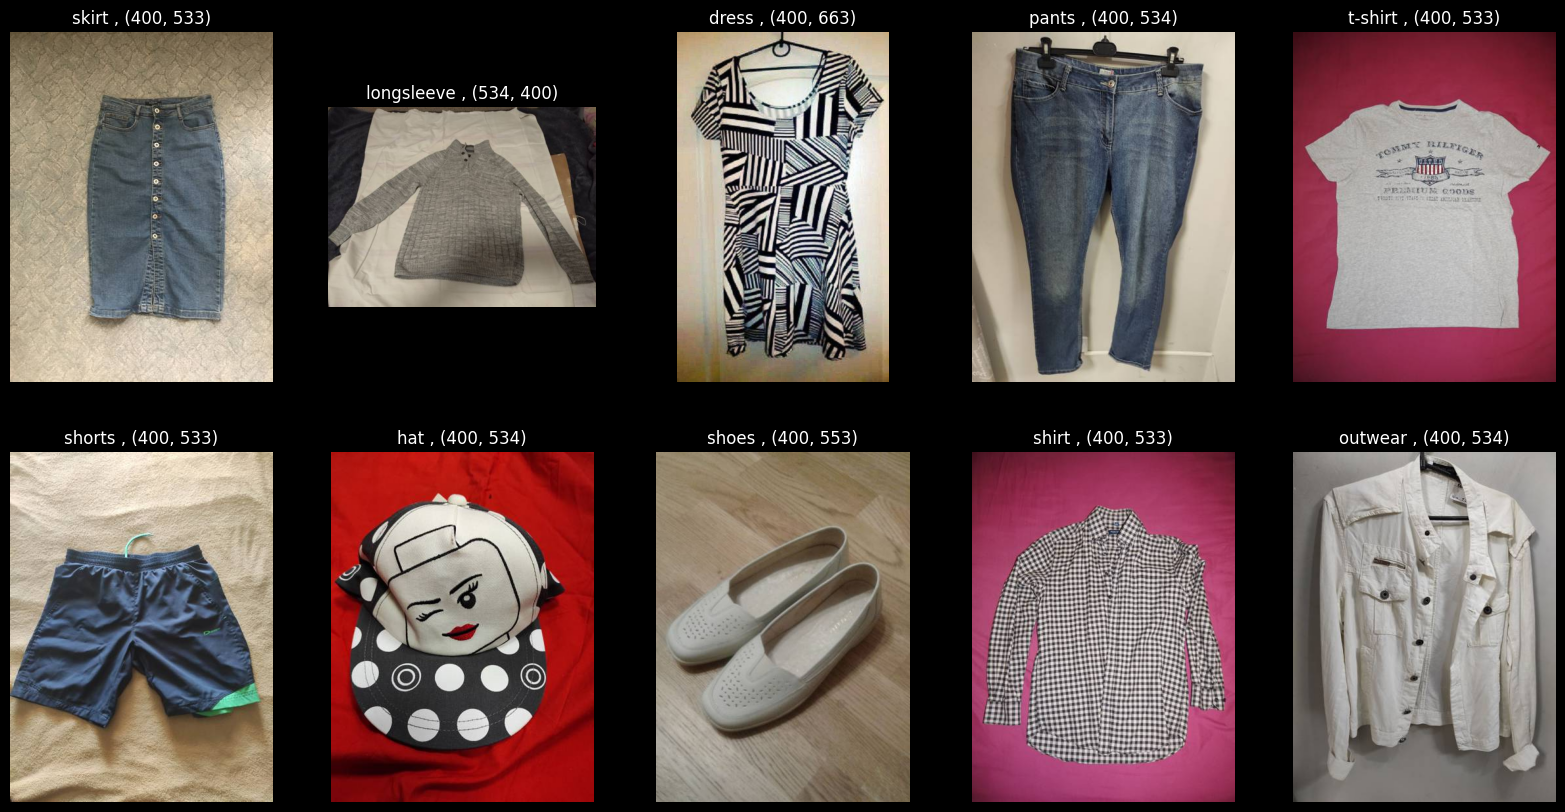

In [8]:
#plot images:
for i , (cls , img) in enumerate(imagedict.items()):
    plt.subplot(2 , 5, i + 1)
    plt.imshow(img)
    plt.title(f"{cls} , {img.size}")
    plt.axis('off')



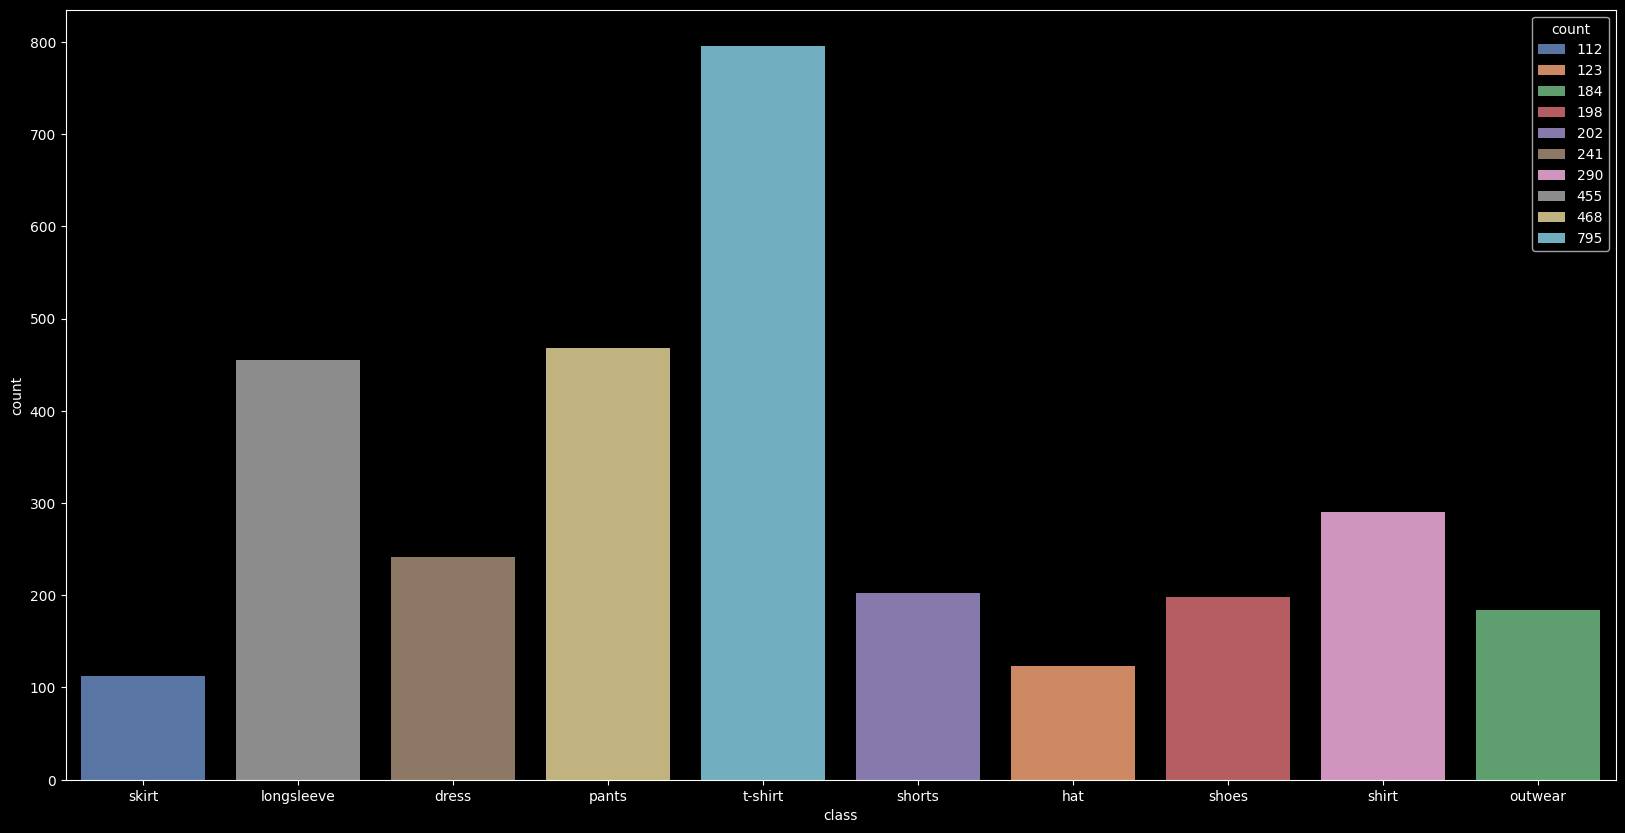

In [9]:
countdf = pd.DataFrame({
    "class":countdict.keys(),
    "count":countdict.values()
})
sns.barplot(countdf , x = 'class' , y = 'count' , hue='count' , palette = 'deep')
plt.show()

In [12]:
# upload the train data to a tf.data.Dataset object:
print(f"Loading train data")
traindataset = tf.keras.utils.image_dataset_from_directory(trainfile , shuffle = True)
print(f"Loading test and validation data")
datafile = '../data/fashion_images/clothing-dataset-small'
testdataset = tf.keras.utils.image_dataset_from_directory(f'{datafile}/test' , shuffle = False)
validationdataset = tf.keras.utils.image_dataset_from_directory(f"{datafile}/validation" , shuffle = False)

Loading train data
Found 3068 files belonging to 10 classes.
Loading test and validation data
Found 372 files belonging to 10 classes.
Found 341 files belonging to 10 classes.


In [13]:
height , width = 128 , 128
dataprocesslayer = keras.Sequential(name = 'dataProcessLayer' , layers = [
    layers.Resizing(height , width),
    layers.Rescaling(1.0 / 255)
] )
traindata = traindataset.map(lambda x , y: (dataprocesslayer(x) , y))
validationdata = validationdataset.map(lambda x , y : (dataprocesslayer(x) , y))
testdata = testdataset.map(lambda x , y: (dataprocesslayer(x) , y))

In [14]:
#build ann model:

nclasses = 10
hidden1 , hidden2 = 1024 , 256

nn = keras.Sequential(name = 'nn' , layers = [
    layers.Flatten(input_shape = (height , width , 3)),
    layers.Dense(units = hidden1 , activation = 'relu'),
    layers.Dense(units = hidden2 , activation = 'relu'),
    layers.Dense(units = nclasses , activation = 'softmax')
])

nn.summary()

/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "nn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    50,332,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,597,642 (193.01 MB)

 Trainable params: 50,597,642 (193.01 MB)

 Non-trainable params: 0 (0.00 B)

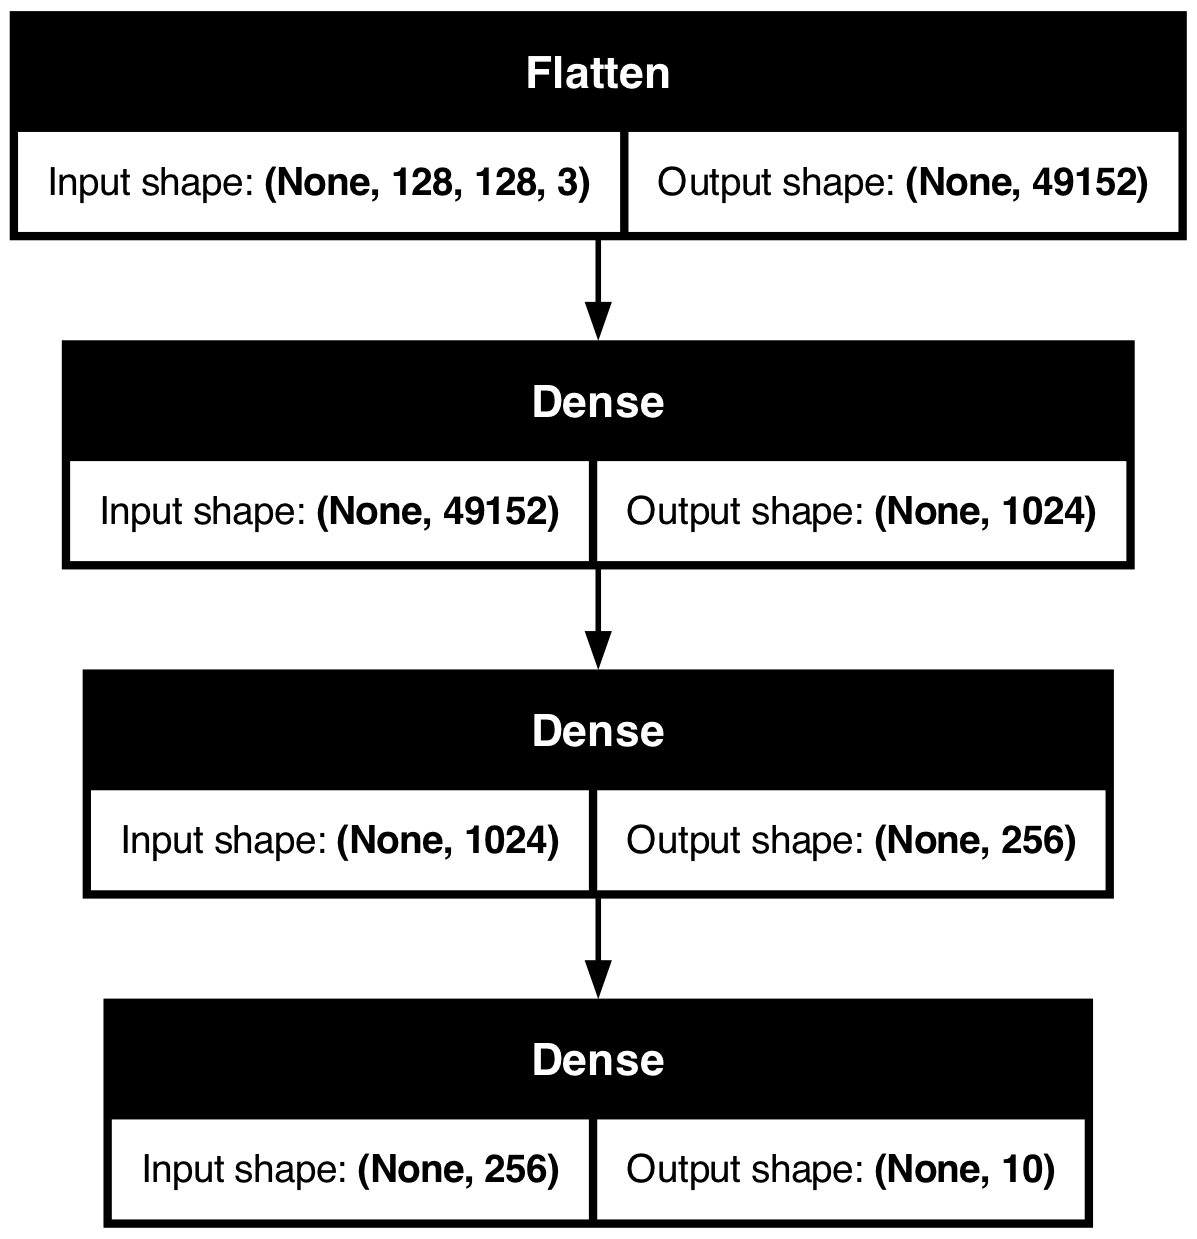

In [15]:
tf.keras.utils.plot_model(nn, show_shapes = True)

In [16]:
def compile_train(model , traindata , valdata , epochs= 10, cpath = './models/nnx.keras'):
    model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
    history = model.fit(traindata , validation_data = valdata , epochs = epochs)
    model.save(cpath)
    return history

In [17]:
#functiont to plot training metrics:
def plot_metrics( history , metrics = ['accuracy' , 'loss' , 'learning_rate']):
    f , ax = plt.subplots(1 , len(metrics) , figsize = (10 * len(metrics) , 8))
    print(ax.shape)
    for i , metric in enumerate(metrics):
        ax[i].plot(history.history[metric] , label = metric)
        # ax[i].set_xticks(fontsize = 15)
        # annot_min_max(history.history[metric] , ax = ax[i])
        if 'val_' + metric in history.history:
            ax[i].plot(history.history['val_' + metric] , label = 'val_' + metric)
            # annot_min_max(history.history["val_" + metric] , ax = ax[i])
        ax[i].legend(fontsize = 15)
    # plt.tight_layout()

In [18]:
# nnhist = compile_train(nn , traindata , validationdata , cpath = './models/nn.keras')
# plot_metrics(nnhist)

In [19]:
nn.save('./models/nn1.keras')

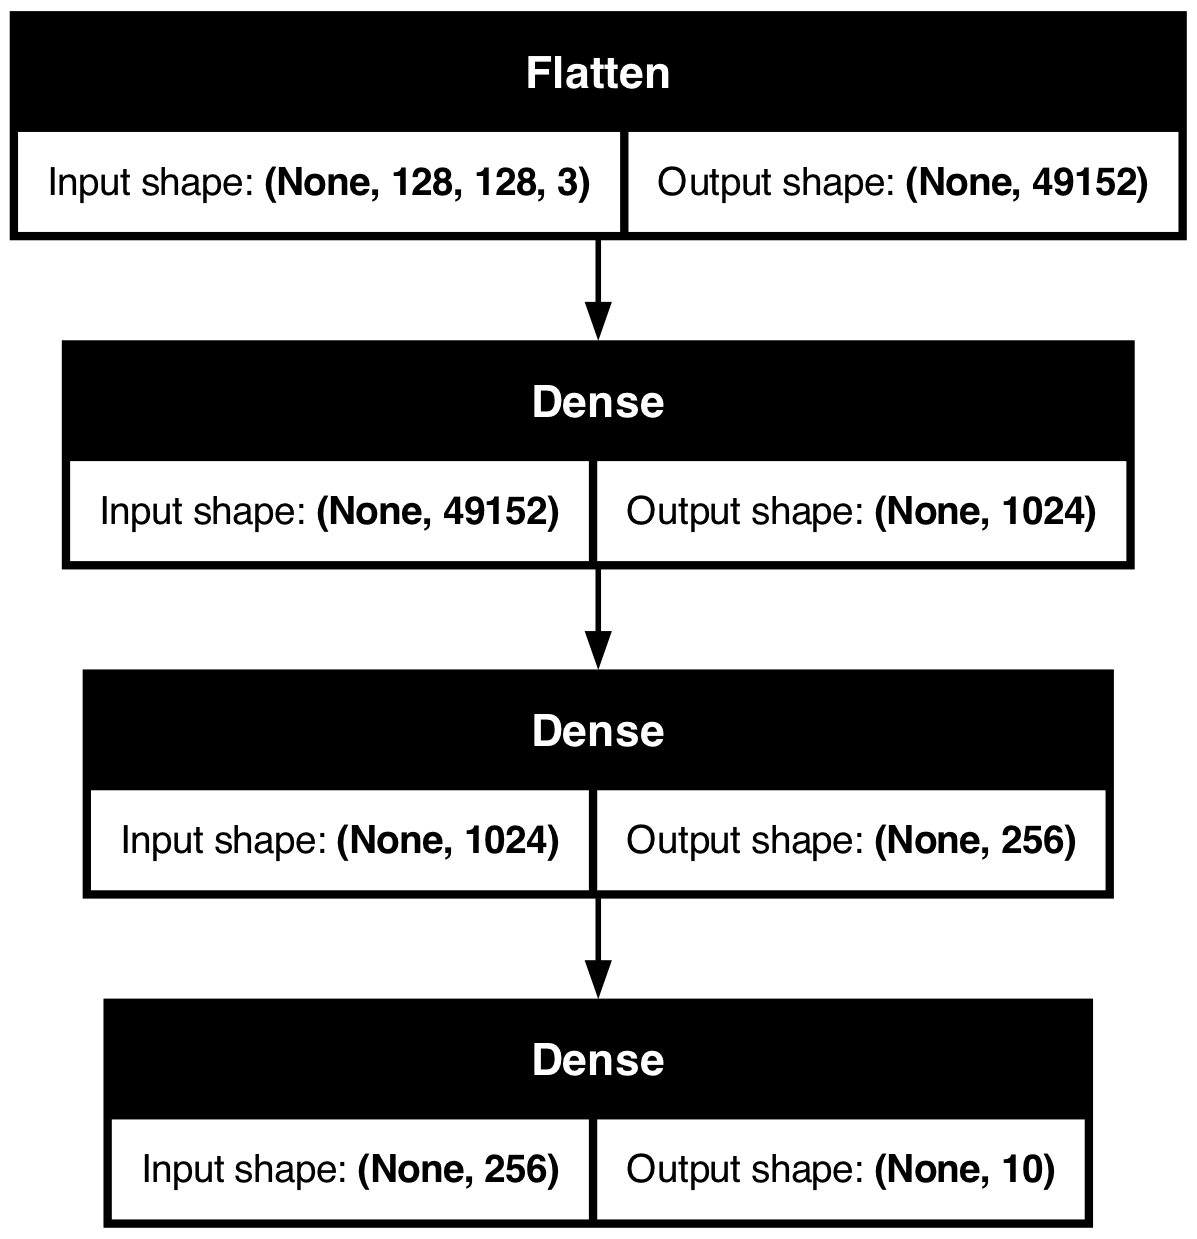

In [20]:
nn2 = tf.keras.models.load_model('./models/nn1.keras')
# nnhist = nn2.losses
tf.keras.utils.plot_model(nn2 , show_shapes= True)

In [21]:
preds = nn2.predict(testdata)

12/12 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step


In [22]:
from sklearn.metrics import accuracy_score
ypreds = tf.argmax(preds , axis = 1)
ytest = tf.concat([y for x , y in testdata] , axis = 0)
images = tf.concat([x for x , y in testdata] , axis = 0)
print(accuracy_score(ypreds , ytest))

0.09408602150537634


2025-09-18 11:48:51.633488: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-18 11:48:51.696913: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.09408602150537634


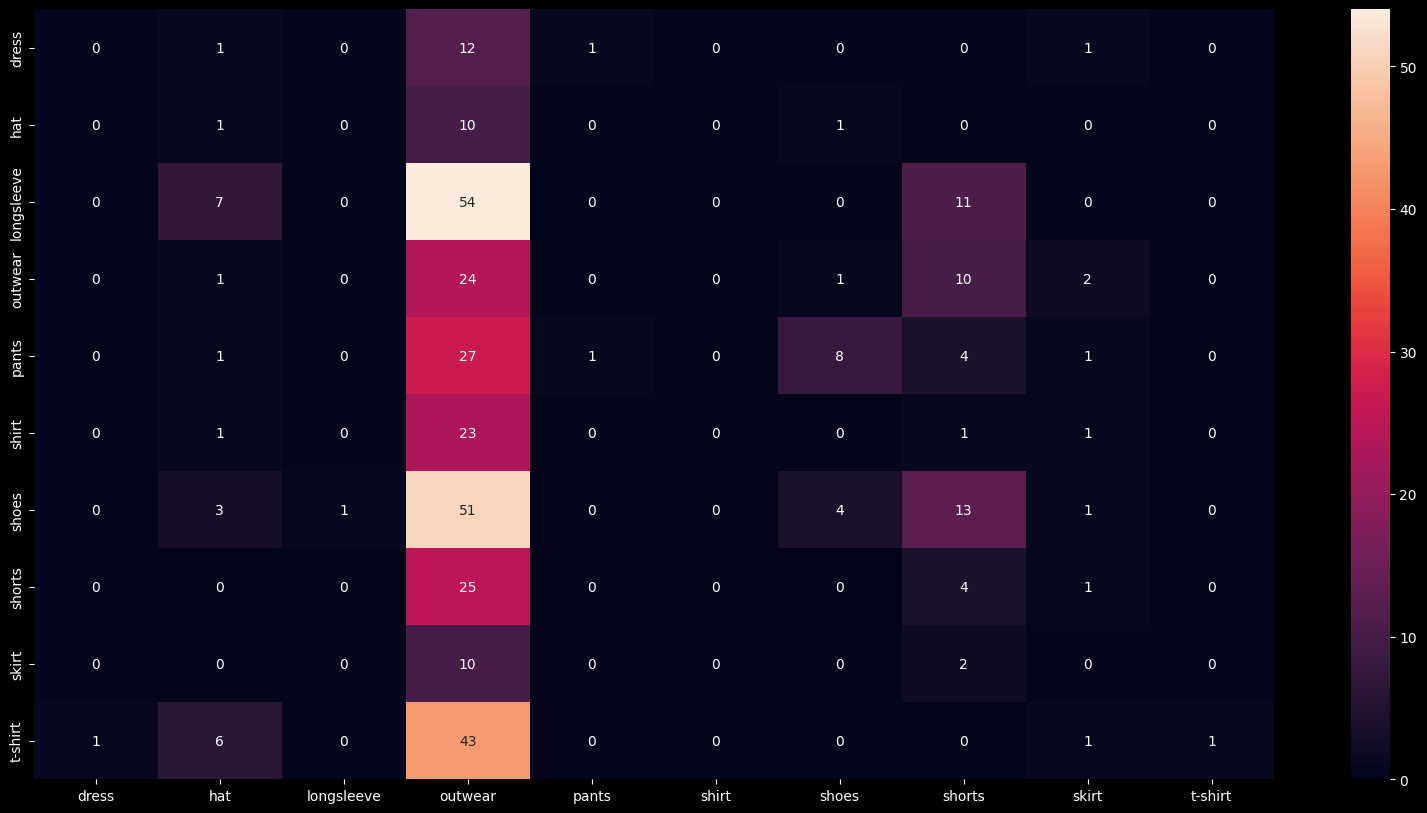

In [23]:
from sklearn import metrics
def confusionmatrix(model , data , labels):
    ypreds = tf.argmax(model.predict(data) , axis = 1)
    ytrue = tf.concat([y for x , y in data] , axis = 0)
    print(f"{metrics.accuracy_score(ypreds , ytrue)}")
    cm = metrics.confusion_matrix(ytrue , ypreds)
    sns.heatmap(cm , annot = True , xticklabels= labels , yticklabels= labels , fmt = 'g')
    plt.show()

confusionmatrix(nn , testdata , testdataset.class_names)

In [24]:
#plot samples along with their predicted probabilities:

def plot_image(pred_labels , true_label , image , class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(image)

    pred_label = np.argmax(pred_labels , axis = 0)
    color = 'blue' if pred_label == true_label else 'red'
    plt.xlabel(f"{class_names[pred_label]} , {np.round(np.max(pred_labels) * 100 , 2)} , ({class_names[true_label]})" , color = color)


def plot_predictions(ypreds , ytrue):
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10) , ypreds , color = 'gray')
    plt.ylim([0,1])
    predLabel = np.argmax(ypreds)
    thisplot[predLabel].set_color('red')
    thisplot[ytrue].set_color('blue')

[203, 213, 315, 86, 322, 99, 357, 215, 286, 117, 93, 343, 237, 196, 365]


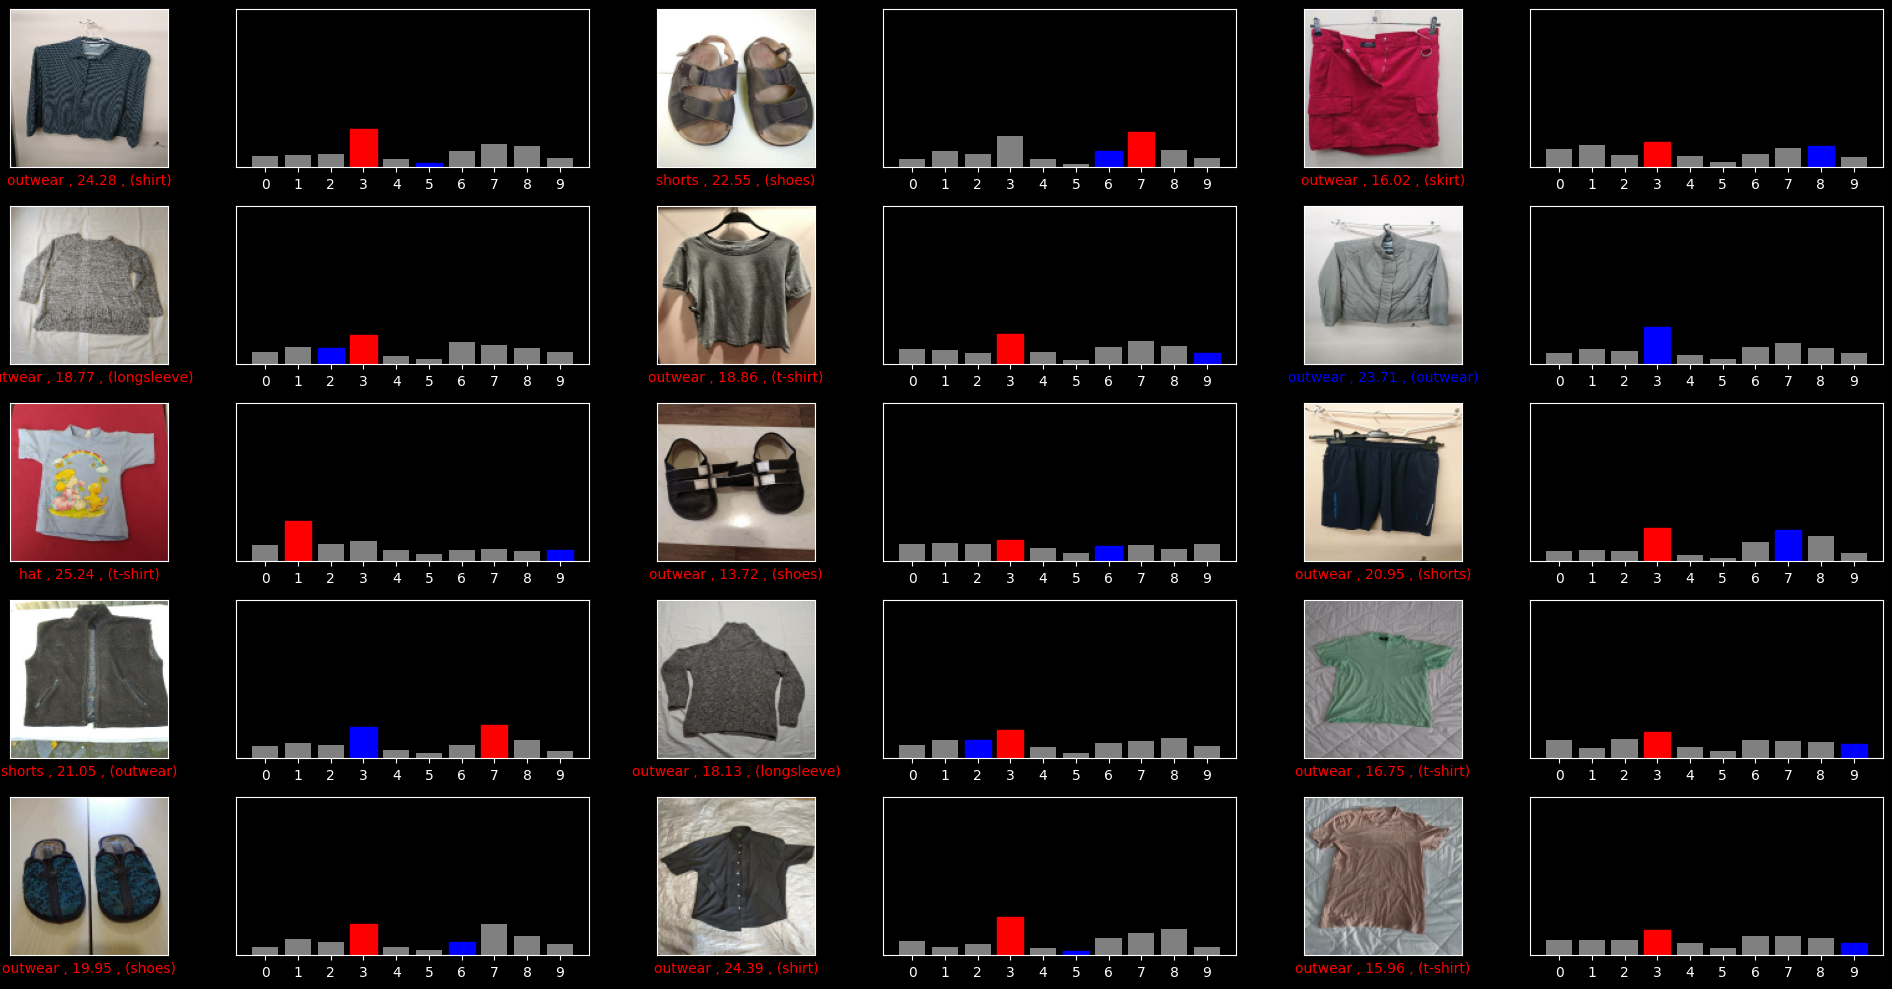

In [25]:
indices = random.sample(range(len(images)) , 15)
print(indices)
for i , index in enumerate(indices):
    # print(2 * i + 1 , 2 * i + 2)
    plt.subplot(5 , 6, 2 *i + 1)
    plot_image(preds[index] , ytest[index] , images[index] , testdataset.class_names)
    plt.subplot(5 , 6, 2 * i + 2)
    plot_predictions(preds[index] , ytest[index])

plt.tight_layout()
plt.show()

class: dress
class: dress
class: dress
class: dress
class: dress


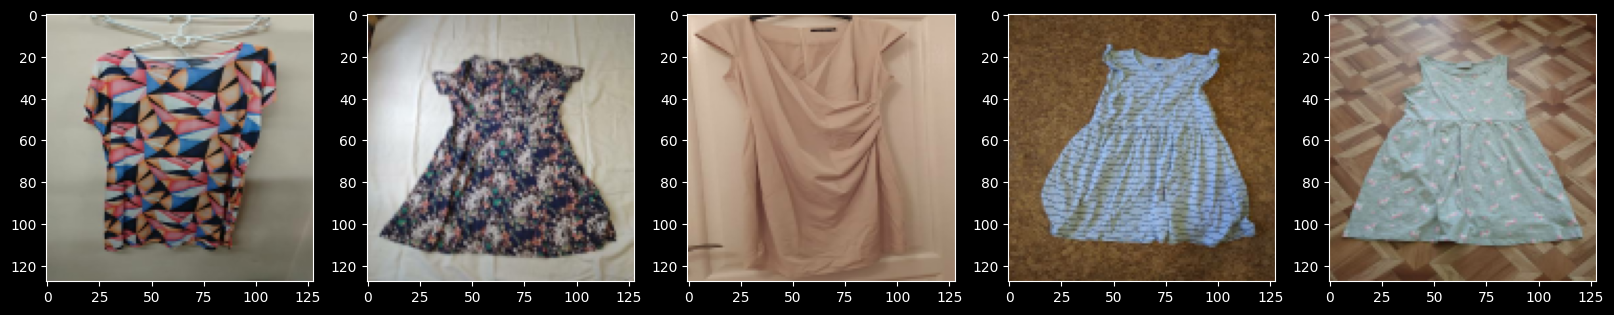

In [26]:
for i in range(5):
        print(f'class: {testdataset.class_names[ytest[i]]}')
        plt.subplot(1 , 5, i + 1)
        plt.imshow(images[i])

## basic cnn model:


In [27]:
def base_model(height = 128 , width = 128):
    nclasses = 10
    hidden1 = 256
    model = keras.Sequential(name = 'basic_cnn' , layers = [
        layers.Conv2D(filters = 16 , kernel_size = 3 , padding = 'same' , activation = 'relu'),
        # input_shape = (height , width , 3)
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dense(units = hidden1 , activation = 'relu'),
        layers.Dense(units = nclasses , activation = 'softmax')
    ])
    model.build(input_shape = (None , height , width , 3))
    return model

In [28]:
cnn = base_model()
cnn.summary()

Model: "basic_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,780,490 (64.01 MB)

 Trainable params: 16,780,490 (64.01 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# hist = compile_train(cnn , traindata , validationdata , 10)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0.4838709677419355


2025-09-18 11:48:53.932889: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


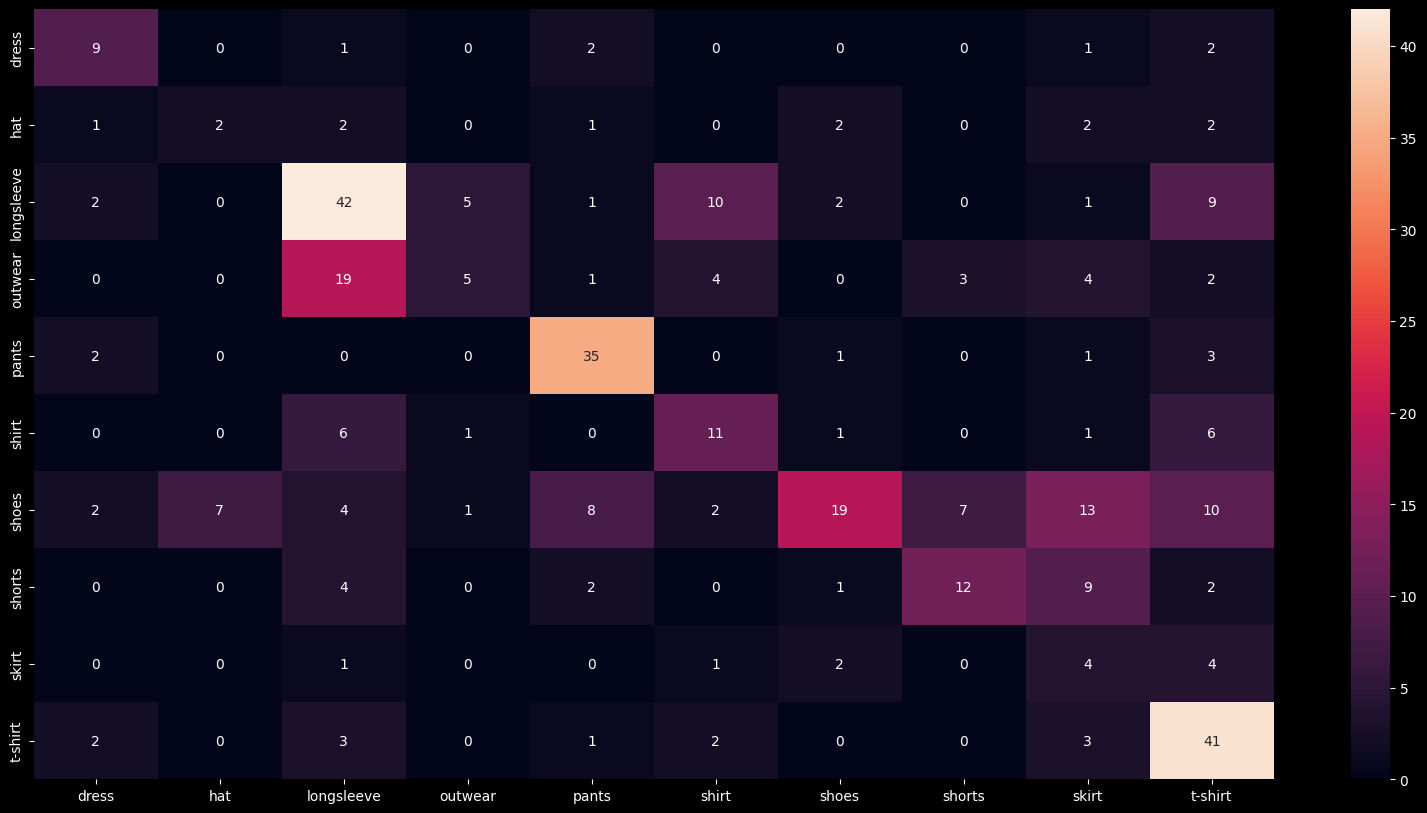

In [30]:
cnn = tf.keras.models.load_model('./models/cnn.keras')
confusionmatrix(cnn , testdata , testdataset.class_names)

## Augmentation:


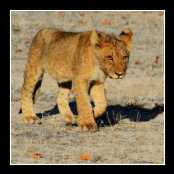

array([[<Axes: >]], dtype=object)

In [31]:
def load_sample(outputsize = (300 , 300)):
    sample = tf.keras.utils.get_file(fname = 'sample.jpg' , origin = 'https://t3638486.p.clickup-attachments.com/t3638486/a0a4f633-2963-4e06-acae-2ad1d12eba3e/sample.jpg' , cache_dir = './models')

    sample = tf.keras.utils.load_img(sample , target_size = outputsize)
    sample = tf.keras.utils.img_to_array(sample)
    return sample


def show_images(images , nrows , ncols , scale = 2):
    aspect_ration = images[0].shape[0] / images[0].shape[1]
    figsize = (ncols * scale , nrows * scale * aspect_ration)

    _ , axes = plt.subplots(nrows , ncols , figsize = figsize , squeeze = False)
    # print(axes)

    for i in range(nrows):
        for j in range(ncols):
            if nrows != 1:
                axes[i][j].imshow(images[i * ncols + j].astype('uint8'))
                axes[i][j].axes.get_xaxis().set_visiblity(False)
                axes[i][j].axes.get_yaxis().set_visiblity(False)

            else:
                axes[i][j].imshow(images[i * ncols + j].astype('uint8'))
                axes[i][j].axes.get_xaxis().set_visible(False)
                axes[i][j].axes.get_yaxis().set_visible(False)

    plt.subplots_adjust(hspace = 0.1 , wspace = 0)
    plt.show()
    return axes


def apply(image , augmentation , nrows = 1 , ncols = 4 , scale = 3):
    y = [augmentation(image).numpy() for _ in range(nrows * ncols)]
    show_images(y , nrows , ncols , scale = scale)

sample = load_sample()

show_images([sample] , 1 , 1)

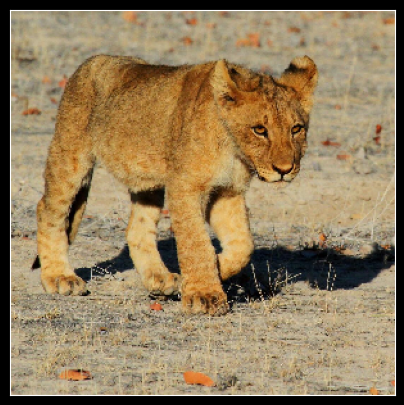

array([[<Axes: >]], dtype=object)

In [32]:
tf.keras.backend.clear_session()
sample = load_sample()
show_images([sample] , 1 , 1 ,5)

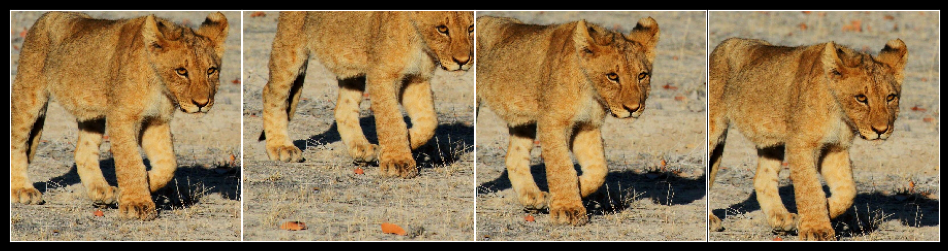

In [33]:
# random crop:
cropped = tf.keras.layers.RandomCrop(height = 224, width = 224)
apply(sample , cropped)

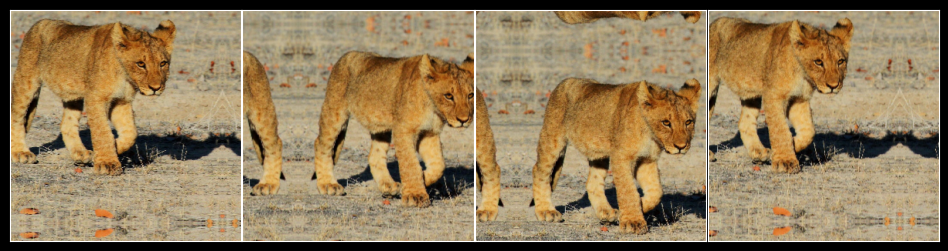

In [34]:
# random translation:
translate = tf.keras.layers.RandomTranslation( height_factor = (-0.2, 0.3),
    width_factor = (-0.2, 0.3))
apply(sample , translate)

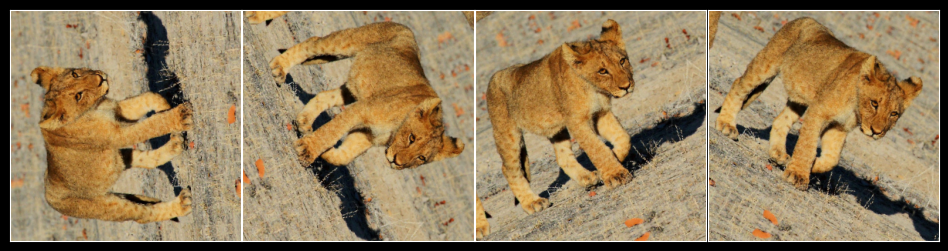

In [35]:
#random rotation:
rotate = tf.keras.layers.RandomRotation(factor = (-0.2, 0.3))
apply(sample , rotate)

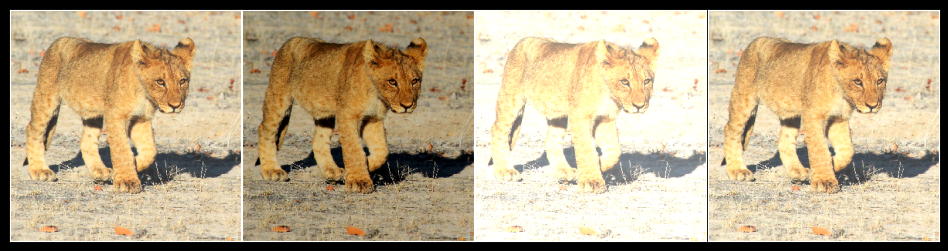

In [36]:
#random brightness:
brightness = tf.keras.layers.RandomBrightness((-0.2 , 0.5))
apply(sample , brightness)

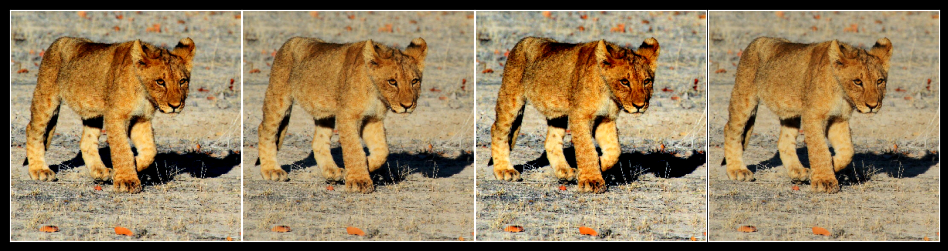

In [37]:
#random contrast:
contrast = tf.keras.layers.RandomContrast((0.2 , 0.9))
apply(sample , contrast)

In [38]:
def arch_2(height=128, width=128):
    num_classes = 10
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_2",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [39]:
cnn2 = arch_2()
cnn2.summary()

/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_cnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             

 Total params: 463,978 (1.77 MB)

 Trainable params: 462,474 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [40]:
def compile_train2(model , traindata , valdata , epochs , cpath):
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=5, min_lr=0.00001
        ),
        # keras.callbacks.ModelCheckpoint('./models', save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, min_delta=0.001, mode='min'
        )
    ]

    model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
    hist = model.fit(traindata , validation_data = valdata , epochs = epochs , callbacks = callbacks)
    model.save(cpath)
    return hist



In [41]:
# create new train , val and test dataset to apply on the new model which includes data augmentation in trainset.

def pre_process(traindataset , validationdataset , testdataset , target_height = 128 , target_width = 128):

    data_preprocess = tf.keras.Sequential(
        name = 'data_preprocess',
        layers = [
            layers.Resizing(target_height , target_width),
            layers.Rescaling(1.0 / 255)
        ]
    )

    data_augmentation = tf.keras.Sequential(
        name = 'data_augmentation',
        layers = [
            layers.Resizing(156 , 156),
            layers.RandomCrop(target_height , target_width),
            layers.Rescaling(1.0 / 255)
        ]
    )

    traindata = traindataset.map(lambda x , y : (data_augmentation(x) , y) , num_parallel_calls= tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

    validationdata = validationdataset.map(lambda x , y : (data_preprocess(x) , y) , num_parallel_calls= tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

    testdata = testdataset.map(lambda x , y : (data_preprocess(x) , y) , num_parallel_calls= tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

    return traindata , validationdata , testdata


traindata2 , validationdata2 , testdata2 = pre_process(traindataset , validationdataset , testdataset)


In [42]:
cnn2hist = compile_train2(cnn2 , traindata2 , validationdata2 , epochs = 20 , cpath = './models/cnn2.keras')

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 559s 6s/step - accuracy: 0.1946 - loss: 3.0680 - val_accuracy: 0.1994 - val_loss: 2.5654 - learning_rate: 0.0010
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.3015 - loss: 2.3783 - val_accuracy: 0.2375 - val_loss: 3.0867 - learning_rate: 0.0010
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.3694 - loss: 2.1368 - val_accuracy: 0.3079 - val_loss: 3.0847 - learning_rate: 0.0010
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.4323 - loss: 1.8492 - val_accuracy: 0.3050 - val_loss: 2.2533 - learning_rate: 0.0010
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.4442 - loss: 1.7794 - val_accuracy: 0.4428 - val_loss: 1.7427 - learning_rate: 0.0010
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.4812 - loss: 1.5865 - val_accuracy: 0.4633 - val_loss: 1.5886 - learning_rate: 0.0010
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.5098 - loss: 1.4931 - v

(3,)


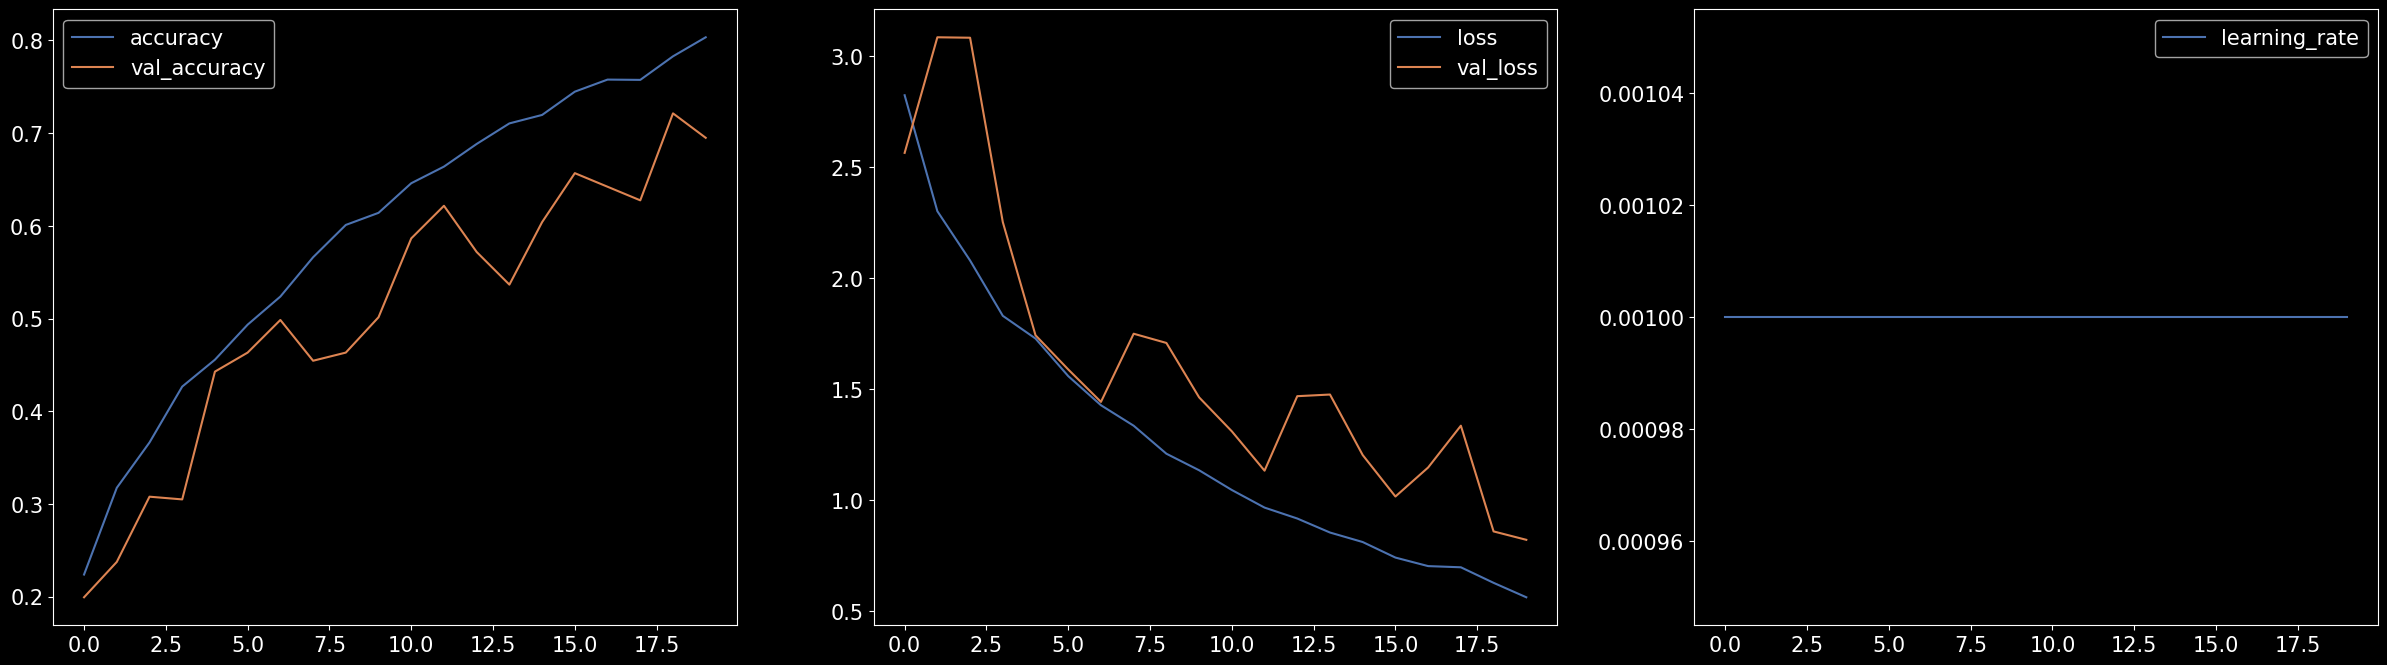

In [46]:
#functiont to plot training metrics:
def plot_metrics( history , metrics = ['accuracy' , 'loss' , 'learning_rate']):
    f , ax = plt.subplots(1 , len(metrics) , figsize = (10 * len(metrics) , 8))
    print(ax.shape)
    for i , metric in enumerate(metrics):
        ax[i].plot(history.history[metric] , label = metric)
        ax[i].tick_params(axis = 'x' , labelsize = 15)
        ax[i].tick_params(axis = 'y' , labelsize = 15)
        # annot_min_max(history.history[metric] , ax = ax[i])
        if 'val_' + metric in history.history:
            ax[i].plot(history.history['val_' + metric] , label = 'val_' + metric)
            # annot_min_max(history.history["val_" + metric] , ax = ax[i])
        ax[i].legend(fontsize = 15)
    # plt.tight_layout()
plot_metrics(cnn2hist)

In [ ]:
cnn2hist.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])